# Chess Engine with PyTorch

## Imports

In [1]:
import os
import numpy as np 
import time
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader     
from chess import pgn 
from tqdm import tqdm 
import chess
from auxiliary_func import create_input_and_value, encode_moves
from dataset import ChessDataset
from model import ChessModel
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt

# Data preprocessing

## Load data

In [2]:
def load_pgn(file_path, limit_per_file=None):
    games = []
    with open(file_path, 'r') as pgn_file:
        count = 0
        while True:
            game = pgn.read_game(pgn_file)
            if game is None:
                break
            games.append(game)
            count += 1
            if limit_per_file is not None and count >= limit_per_file:
                break
    return games

# Lister tous les fichiers PGN
files = [file for file in os.listdir("../data/pgn") if file.endswith(".pgn")]
LIMIT_OF_FILES = min(len(files), 28)
LIMIT_PER_FILE = 800  # Limite de parties par fichier

# Charger les fichiers avec une barre de progression
games = []
for i, file in enumerate(tqdm(files[:LIMIT_OF_FILES], desc="Loading PGN files")):
    games.extend(load_pgn(f"../data/pgn/{file}", limit_per_file=LIMIT_PER_FILE))

print(f"GAMES PARSED: {len(games)}")

Loading PGN files: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

GAMES PARSED: 800


In [3]:
print(f"GAMES PARSED: {len(games)}")

GAMES PARSED: 800


## Convert data into tensors

In [4]:
X, y_policy_str, y_value = create_input_and_value(games)

print(f"NUMBER OF SAMPLES: {len(y_policy_str)}")

X = X[0:2500000]
y_policy_str = y_policy_str[0:2500000]
y_value = y_value[0:2500000]

y_policy, move_to_int = encode_moves(y_policy_str)
num_classes = len(move_to_int)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_policy_tensor = torch.tensor(y_policy, dtype=torch.long)
y_value_tensor = torch.tensor(y_value, dtype=torch.float32)

NUMBER OF SAMPLES: 69864


# Preliminary actions

In [5]:
# Create Dataset and DataLoader
dataset = ChessDataset(X_tensor, y_policy_tensor, y_value_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=cpu_count())

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Model Initialization
model = ChessModel(num_classes=num_classes).to(device)

# Pour la tête policy (classification du coup)
criterion_policy = nn.CrossEntropyLoss()
# Pour la tête value (régression de la valeur de la position)
criterion_value  = nn.MSELoss()

# Poids relatif de la value dans la loss totale
lambda_value = 1.0

optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using device: cuda


# Training

Epoch 1/50 — avg loss: 6.5735


Epoch 2/50 — avg loss: 6.1890


Epoch 3/50 — avg loss: 6.0882


Epoch 4/50 — avg loss: 6.0107


Epoch 5/50 — avg loss: 5.9477


Epoch 6/50 — avg loss: 5.8872


Epoch 7/50 — avg loss: 5.8314


Epoch 8/50 — avg loss: 5.7716


Epoch 9/50 — avg loss: 5.7161


Epoch 10/50 — avg loss: 5.6565


Epoch 11/50 — avg loss: 5.5973


Epoch 12/50 — avg loss: 5.5339


Epoch 13/50 — avg loss: 5.4700


Epoch 14/50 — avg loss: 5.4022


Epoch 15/50 — avg loss: 5.3322


Epoch 16/50 — avg loss: 5.2653


Epoch 17/50 — avg loss: 5.2002


Epoch 18/50 — avg loss: 5.1352


Epoch 19/50 — avg loss: 5.0684


Epoch 20/50 — avg loss: 5.0075


Epoch 21/50 — avg loss: 4.9447


Epoch 22/50 — avg loss: 4.8882


Epoch 23/50 — avg loss: 4.8258


Epoch 24/50 — avg loss: 4.7696


Epoch 25/50 — avg loss: 4.7124


Epoch 26/50 — avg loss: 4.6585


Epoch 27/50 — avg loss: 4.6073


Epoch 28/50 — avg loss: 4.5561


Epoch 29/50 — avg loss: 4.5063


Epoch 30/50 — avg loss: 4.4582


Epoch 31/50 — avg loss: 4.4118


Epoch 32/50 — avg loss: 4.3652


Epoch 33/50 — avg loss: 4.3147


Epoch 34/50 — avg loss: 4.2728


Epoch 35/50 — avg loss: 4.2316


Epoch 36/50 — avg loss: 4.1889


Epoch 37/50 — avg loss: 4.1453


Epoch 38/50 — avg loss: 4.1068


Epoch 39/50 — avg loss: 4.0649


Epoch 40/50 — avg loss: 4.0285


Epoch 41/50 — avg loss: 3.9900


Epoch 42/50 — avg loss: 3.9505


Epoch 43/50 — avg loss: 3.9151


Epoch 44/50 — avg loss: 3.8818


Epoch 45/50 — avg loss: 3.8440


Epoch 46/50 — avg loss: 3.8076


Epoch 47/50 — avg loss: 3.7701


Epoch 48/50 — avg loss: 3.7383


Epoch 49/50 — avg loss: 3.7037


Epoch 50/50 — avg loss: 3.6723


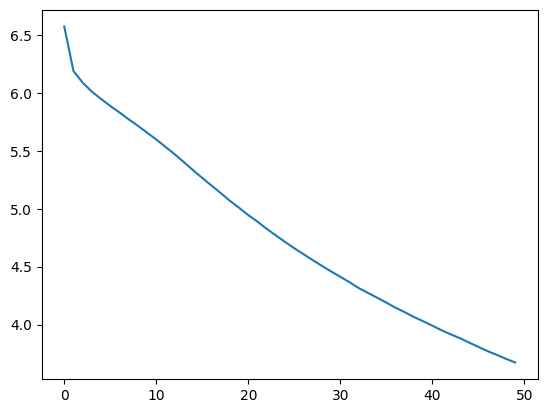

In [ ]:
num_epochs = 50
model.to(device)

epoch_losses = []
epoch_accs   = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total   = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for inputs, labels_policy, labels_value in pbar:
        inputs        = inputs.to(device, non_blocking=True)
        labels_policy = labels_policy.to(device, non_blocking=True)
        labels_value  = labels_value.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits, values = model(inputs)

        # losses
        Lp   = criterion_policy(logits, labels_policy)
        Lv   = criterion_value(values, labels_value)
        loss = Lp + lambda_value * Lv
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

        # accuracy batch
        preds = logits.argmax(dim=1)
        correct += (preds == labels_policy).sum().item()
        total   += labels_policy.size(0)

        pbar.set_postfix(loss=running_loss / (pbar.n + 1), refresh=False)

    # fin d'époque
    avg_loss = running_loss / len(dataloader)
    acc      = correct / total

    epoch_losses.append(avg_loss)
    epoch_accs.append(acc)

    print(f"Epoch {epoch}/{num_epochs} — avg loss: {avg_loss:.4f}, acc: {acc:.4f}")

# Tracé de l'accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), epoch_accs, marker='o')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()


# Save the model and mapping

In [ ]:
# Save the model
torch.save(model.state_dict(), "../models/noob.pth")

In [ ]:
import pickle

with open("../models/heavy_move_to_int", "wb") as file:
    pickle.dump(move_to_int, file)